In [ ]:
!pip uninstall -y torch

# !pip install torch==1.8.2+cpu -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
# !pip install torch==1.10.0 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html

# !pip install -q cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl


Found existing installation: torch 1.10.0+cu111
Uninstalling torch-1.10.0+cu111:
  Successfully uninstalled torch-1.10.0+cu111
     |████████████████████████████████| 149.9 MB 1.1 MB/s 
     |████████████████████████████████| 831.4 MB 2.5 kB/s 
     |████████████████████████████████| 57 kB 4.9 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
earthengine-api

In [ ]:
import autograd.numpy as np # to handle matrix and data operation
from autograd import grad, jacobian

import pandas as pd # to red csv and handle dataframe
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, AutoMinorLocator
from tqdm.notebook import tqdm
import copy
from mpl_toolkits.mplot3d import Axes3D
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pll
import torch_xla.utils.serialization as xser

# import pytorch_lightning as pl
# from pytorch_lightning.core.decorators import auto_move_data

import torchvision.transforms as transforms
import torchvision.datasets
# import torchattacks

# from sklearn.model_selection import train_test_split
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
import scipy.stats as sps
import scipy.signal as spy_sig
import scipy.ndimage as ndimage
import scipy.optimize as spy_opt
import random
import os
import pickle

random_seed = 1
torch.backends.cudnn.enabled = False

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = xm.xla_device()

torch_xla.core.xla_model.set_rng_state(1, device=device)
np.random.seed(0)
torch.manual_seed(0)


In [ ]:
cd drive/MyDrive/Robustness_analysis/

/content/drive/MyDrive/Robustness_analysis


In [ ]:
def load_dataset(download=False, dataset='cifar'):
  dataset = dataset.lower()
  batch_size = 100

  trans_og = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  
  # AlexTransform = transforms.Compose([
  #   transforms.Resize(256),
  #   transforms.CenterCrop(224),
  #   transforms.ToTensor(),
  #   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

  AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])
  
  imagenet_trans = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  
  # trans =  transforms.Compose(
  #   [transforms.ToTensor(),
  #    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  trans = trans_og

  if dataset == 'cifar':
    print("CIFAR10")#
    trans =  transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_dataset_ = torchvision.datasets.CIFAR10(root=r"Dataset/CIFAR10", train=True,
                                                  transform=trans, download=download)
    test_dataset_ = torchvision.datasets.CIFAR10(root=r"Dataset/CIFAR10", train=False, transform=trans)

  elif dataset == 'mnist':
    print("MNIST")
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset_ = torchvision.datasets.MNIST(root=r"Dataset/", train=True,
                                                transform=trans, download=download)
    test_dataset_ = torchvision.datasets.MNIST(root=r"Dataset/", train=False, transform=trans)

  else:
    train_dataset_ = torchvision.datasets.CIFAR10(root=r"Dataset/CIFAR10", image_set = 'test',
                                                  transform=trans, download=download)
    test_dataset_ = torchvision.datasets.CIFAR10(root=r"Dataset/CIFAR10", train=False, transform=trans)

  train_loader_ = DataLoader(dataset=train_dataset_, num_workers=2, batch_size=batch_size, shuffle=True)
  test_loader_ = DataLoader(dataset=test_dataset_, num_workers=2, batch_size=100, shuffle=True)

  return train_loader_, test_loader_


train_loader, test_loader = load_dataset(download=False, dataset='mnist')


MNIST


In [ ]:
torchvision.models.squeezenet1_1(num_classes=10).features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = torchvision.models.resnet18(num_classes=200)

    # self.model.features[0][0] =  nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    # self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  ## googlenet
    # self.model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))

    self.loss = nn.CrossEntropyLoss()

##  @auto_move_data
  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_no):
    x, y = batch
    logits = self(x)
    loss = self.loss(logits, y)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.model.parameters(), lr=0.001)

WRAPPED_MODEL = xmp.MpModelWrapper(Model())
model = WRAPPED_MODEL.to(device)
# model = Model()


In [ ]:
def simple_map_fn(index, flags):
  # Sets a common random seed - both for initialization and ensuring graph is the same
  torch.manual_seed(1234)

  # Acquires the (unique) Cloud TPU core corresponding to this process's index
  device = xm.xla_device()  

  # Creates a tensor on this process's device
  t = torch.randn((2, 2), device=device)

  print("Process", index ,"is using", xm.xla_real_devices([str(device)])[0])

  # Barrier to prevent master from exiting before workers connect.
  xm.rendezvous('init')

# Configures training (and evaluation) parameters
flags = {}
flags['batch_size'] = 100
flags['num_workers'] = 2
flags['num_epochs'] = 1
flags['seed'] = 1234

# trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])  #  MNIST SqueezeNet regular

trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # CIFAR10 GoogleNet
# trans = transforms.Compose([transforms.Resize(256), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # for google net CIFAR10
# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])  #  MNIST regular
# trans = transforms.Compose([transforms.Resize(256), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) #  SqueezeNet MNIST

### MobileNetV2 for ImageNet (dataset has not been transformed, keep original Tiny Imagenet dataset)

AlexTransform = transforms.Compose([
  transforms.Resize((227, 227)),
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.CIFAR10(root=r"Dataset/", train=True,
                                            transform=trans, download=False)
test_dataset = torchvision.datasets.CIFAR10(root="Dataset/", train=False,
                                            transform=trans, download=False)

# for train set
train_sampler = torch.utils.data.distributed.DistributedSampler(
  train_dataset,
  num_replicas=xm.xrt_world_size(),
  rank=xm.get_ordinal(),
  shuffle=True)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=100,
    sampler=train_sampler,
    num_workers=2,
    drop_last=True)

# for test set 
test_sampler = torch.utils.data.distributed.DistributedSampler(
  test_dataset,
  num_replicas=xm.xrt_world_size(),
  rank=xm.get_ordinal(),
  shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=100,
    sampler=test_sampler,
    num_workers=2,
    drop_last=True)


***For ImageNet Tiny Dataset***

In [ ]:
class ImageNet(torch.utils.data.Dataset):
  def __init__(self, data_dict, transform=None, target_transform=None):
    self.targets = data_dict['labels']
    self.data = data_dict['images']
    self.classes = data_dict['Classes_dict']

    self.label_keys = self.classes.keys()
    self.label_values = self.classes.values()
    
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    image = self.data[idx]
    label = self.targets[idx]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label


def save_obj(obj, name):
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_imagenet(dir_path):
  train_file_name = "train_set"
  test_file_name = "test_set"

  with (open(dir_path+train_file_name+ '.pkl', "rb")) as openfile:
    while True:
        try:
            train_dict = (pickle.load(openfile))
        except EOFError:
            break

  with (open(dir_path+test_file_name+ '.pkl', "rb")) as openfile:
    while True:
        try:
            test_dict = (pickle.load(openfile))
        except EOFError:
            break
  
  return train_dict, test_dict

path = "Dataset/tiny-imagenet-200/complete_dataset/"
train_dict, test_dict = load_imagenet(path)

trainset = ImageNet(train_dict)
testset = ImageNet(test_dict)

train_sampler = torch.utils.data.distributed.DistributedSampler(
  trainset,
  num_replicas=xm.xrt_world_size(),
  rank=xm.get_ordinal(),
  shuffle=True)

train_loader = torch.utils.data.DataLoader(
  trainset,
  batch_size=100,
  sampler=train_sampler,
  num_workers=2,
  drop_last=True)

test_sampler = torch.utils.data.distributed.DistributedSampler(
  testset,
  num_replicas=xm.xrt_world_size(),
  rank=xm.get_ordinal(),
  shuffle=True)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=100,
    sampler=test_sampler,
    num_workers=1,
    drop_last=True)


In [ ]:
ta, tb = 13, 17

mat = torch.arange(10, 20).reshape(5, 2)
print(mat)
print("\n")

new = torch.zeros_like(mat)

maska = mat >= ta
maskb = mat < tb

new[~maska] = mat[~maska]
new[~maskb] = mat[~maskb]


tensor([[10, 11],
        [12, 13],
        [14, 15],
        [16, 17],
        [18, 19]])




In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  min_val, max_val = torch.min(image), torch.max(image)
  # Collect the element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad

  # Adding clipping to maintain [0,1] range
  # perturbed_image = torch.clamp(perturbed_image, min_val, max_val)
  # Return the perturbed image
  return perturbed_image



def run_fgsm_attack(model_, test_loader, eps):

  model_.eval()
  model_ = model_.to(device)

  adv_examples = []
  criterion = nn.CrossEntropyLoss()
  criterion.to(device)

  correct_adv, correct_og, total, running_loss = 0, 0, 0, 0
  # Loop over all examples in test set
  for data, target in tqdm(test_loader):
    # Send the data and label to the device
    data, target = data.to(device), target.to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    # Forward pass the data through the model
    output = model_(data)# .to(device)
    _, init_pred = torch.max(output.data, 1)

    # If the initial prediction is wrong, dont bother attacking, just move on
    # if init_pred.item() != target.item():
    #   continue

    # Calculate the loss
    loss = criterion(output, target)
    loss = loss.to(device)

    # Zero all existing gradients
    model_.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = data.grad.data

    # Call FGSM Attack
    perturbed_data = fgsm_attack(data, eps, data_grad)

    # Re-classify the perturbed image
    output = model_(perturbed_data).to(device)
    test_loss = criterion(output, target).to(device)

    # Check for success
    _, final_pred = torch.max(output.data, 1)

    running_loss += test_loss.item() * data.size(0)
    total += target.size(0)
    correct_adv += (final_pred == target).sum().item()
    correct_og += (init_pred == target).sum().item()

  # Calculate final accuracy for this epsilon
  final_acc_adv = correct_adv / total
  final_acc_og = correct_og / total
  epoch_loss = running_loss / total

  # Return the accuracy and an adversarial example
  return final_acc_adv, final_acc_og, epoch_loss

dataset_name = 'ImageNet'
model_name= 'ResNet18'
# filter_type = "maxmin"
epoch_str = "10"

model_test = Model()
path_dir = 'Saved_models/'+model_name+'/'+dataset_name+'/'
path = path_dir+'Init_1/'+model_name+'_'+dataset_name+'_'+epoch_str+'epochs.ckpt'

checkpoint = torch.load(path, map_location=torch.device('cpu'))
model_test.load_state_dict(checkpoint)
model_test = model_test.to(device)
# print(run_fgsm_attack(model_test, test_loader, 0.011))

eps = 2.7

adv_examples = []
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

correct_adv, correct_og, total, running_loss = 0, 0, 0, 0

para_test_loader = pll.ParallelLoader(test_loader, [device]).per_device_loader(device)
# Loop over all examples in test set
for data, target in tqdm(para_test_loader):
  # Send the data and label to the device
  data, target = data.double().to(device), target.to(device)

  # Set requires_grad attribute of tensor. Important for Attack
  data.requires_grad = True

  # Forward pass the data through the model
  output = model_test(data)# .to(device)
  _, init_pred = torch.max(output.data, 1)

  # If the initial prediction is wrong, dont bother attacking, just move on
  # if init_pred.item() != target.item():
  #   continue

  # Calculate the loss
  loss = criterion(output, target)
  loss = loss.to(device)

  # Zero all existing gradients
  model_test.zero_grad()

  # Calculate gradients of model in backward pass
  loss.backward()

  # Collect datagrad
  data_grad = data.grad.data

  # Call FGSM Attack
  perturbed_data = fgsm_attack(data, eps, data_grad)

  # Re-classify the perturbed image
  output = model_test(perturbed_data).to(device)
  test_loss = criterion(output, target).to(device)

  # Check for success
  _, final_pred = torch.max(output.data, 1)

  running_loss += test_loss.item() * data.size(0)
  total += target.size(0)
  correct_adv += (final_pred == target).sum().item()
  correct_og += (init_pred == target).sum().item()

# Calculate final accuracy for this epsilon
final_acc_adv = correct_adv / total
final_acc_og = correct_og / total
epoch_loss = running_loss / total

print(final_acc_og, final_acc_adv)

  0%|          | 0/100 [00:00<?, ?it/s]

0.7345 0.3683


In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  min_val, max_val = torch.min(image), torch.max(image)
  # Collect the element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad

  # Adding clipping to maintain [0,1] range
  # perturbed_image = torch.clamp(perturbed_image, min_val, max_val)
  # Return the perturbed image
  return perturbed_image


def get_test_names(ex_model_og):
  ex_model = copy.deepcopy(ex_model_og)
  # params, names = count_parameters(ex_model.model)

  model_obj = copy.deepcopy(ex_model.model.state_dict())
  new_names = []

  for p_name, module in list(ex_model.model.named_modules())[1:]:
    nn_ = p_name + ".weight"
    if isinstance(module, nn.Conv2d):
      new_names.append(nn_)
    elif isinstance(module, nn.Linear):
      new_names.append(nn_)

  return new_names, model_obj


def step_filter_func(input_mat, offset, fil_type):
  y = torch.zeros_like(input_mat)
  with torch.no_grad():
    if fil_type == "minmax":
      input_mat_fin = torch.where((input_mat <= offset), y, input_mat)
      # input_mat[ind] *= 0
    elif fil_type == "maxmin":
      input_mat_fin = torch.where((input_mat >= offset), y, input_mat)
    else:
      input_mat_fin = torch.where((input_mat <= offset), y, input_mat)
      
  return input_mat_fin


def save_obj(obj, name):
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def count_zero(x):
  if torch.is_tensor(x):
    return torch.count_nonzero(x==0)
  else:
    return np.count_nonzero(x==0)


device = xm.xla_device()

epochs = [60, 70, 80, 90, 100]
dataset_name = "ImageNet"
# epsilon = 0.77 # (0.38) MNIST ResNet18, (0.75) MNIST ResNet50 
epsilon = 0.5 # 0.035 # CIFAR10 ResNet18 (0.015), ResNet50 (0.02), MNIST_SqueezeNet (0.8)
filter_type = "minmax"
filter_folder = 'Step_'+filter_type+'/'
model_name = "ShuffleNet"

for e_no in epochs:
  print("\n")
  print("running experiment for epoch: ", e_no)
  path = 'Saved_models/'+model_name+'/' + dataset_name + '/'
  file_name = 'Init_3/'+model_name+'_' + dataset_name + "_" + str(e_no) + 'epochs.ckpt'

  checkpoint = torch.load(path+file_name, map_location=torch.device("cpu"))
  # checkpoint = xser.load(path+file_name)
  model_ = Model()
  model_.load_state_dict(checkpoint)
  model_.to(device)
  criterion = nn.NLLLoss()

  mod_names, mod_obj = get_test_names(model_)
  samples_no = 25
  results_dict = {}

  for name in tqdm(mod_names):
    weight = copy.deepcopy(mod_obj[name])
    steps = ((torch.min(weight) - torch.max(weight)) / samples_no) / 2

    if filter_type == "minmax":
      alpha_vals = torch.linspace(torch.min(weight), torch.max(weight), samples_no, device=device)
    elif filter_type == "maxmin":
      alpha_vals = torch.linspace(torch.max(weight), torch.min(weight), samples_no, device=device)
    else:
      alpha_vals = torch.linspace(torch.min(weight), torch.max(weight), samples_no, device=device)

    acc_og_list, acc_adv_list, lss_list, zero_count = [], [], [], []

    # prev = torch.min(alpha_vals) - steps
    # next = prev

    for alpha in alpha_vals:
      model_clone = copy.deepcopy(model_)
      mat = copy.deepcopy(weight)
      mat = mat.to(device)
      filtered_weight = torch.zeros_like(mat)
      new_obj = copy.deepcopy(mod_obj)

      prev = alpha + steps
      next = alpha - steps
      prev, next = prev.to(device), next.to(device)

      if filter_type == "pulseminmax":
        maska = mat >= prev
        maskb = mat < next

        filtered_weight[~maska] = mat[~maska]
        filtered_weight[~maskb] = mat[~maskb]

        # new_obj[name] = filtered_weight
        # z_count += count_zero(filtered_weight)

      else:
        filtered_weight = step_filter_func(mat, alpha, filter_type)

      zero_count.append(count_zero(filtered_weight))
      # change this back to new_obj[name] (and declare new_obj at the beginning of the loop) do this for pulse analysis
      new_obj[name] = filtered_weight
      model_clone.model.load_state_dict(new_obj)
      model_clone = model_clone.to(device)

      criterion = nn.CrossEntropyLoss()
      criterion = criterion.to(device)

      correct_adv, correct_og, total, running_loss = 0, 0, 0, 0
      para_test_loader = pll.ParallelLoader(test_loader, [device]).per_device_loader(device)

      for data, target in para_test_loader:
        # Send the data and label to the device
        data, target = data.double().to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model_clone(data)# .to(device)
        _, init_pred = torch.max(output.data, 1)

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #   continue

        # Calculate the loss
        loss = criterion(output, target)
        loss = loss.to(device)

        # Zero all existing gradients
        model_.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output_adv = model_clone(perturbed_data)# .to(device)
        test_loss = criterion(output, target)# .to(device)

        # Check for success
        _, final_pred = torch.max(output_adv.data, 1)

        running_loss += test_loss.item() * data.size(0)
        total += target.size(0)
        correct_adv += (final_pred == target).sum().item()
        correct_og += (init_pred == target).sum().item()

        del test_loss, target, data

      acc_og = correct_og/total
      acc_adv = correct_adv/total
      lss_ = running_loss/total

      acc_og_list.append(acc_og)
      acc_adv_list.append(acc_adv)
      lss_list.append(lss_)

      del model_clone, filtered_weight, new_obj, para_test_loader

    new_name = name.replace(".weight", "")
    results_dict[new_name] = (acc_og_list, acc_adv_list, zero_count, alpha_vals)

  dict_save_name = path+filter_folder+model_name+"_step_"+filter_type+"_advog3_" + dataset_name + "_" + str(e_no) + "epochs"
  save_obj(results_dict, dict_save_name)




running experiment for epoch:  60


  0%|          | 0/57 [00:00<?, ?it/s]



running experiment for epoch:  70


  0%|          | 0/57 [00:00<?, ?it/s]



running experiment for epoch:  80


  0%|          | 0/57 [00:00<?, ?it/s]



running experiment for epoch:  90


  0%|          | 0/57 [00:00<?, ?it/s]



running experiment for epoch:  100


  0%|          | 0/57 [00:00<?, ?it/s]

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  min_val, max_val = torch.min(image), torch.max(image)
  # Collect the element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad

  # Adding clipping to maintain [0,1] range
  # perturbed_image = torch.clamp(perturbed_image, min_val, max_val)
  # Return the perturbed image
  return perturbed_image


def find_minmax(_obj, _names):
  g_max = 0
  g_min = 0

  for name in _names:
    temp_max = torch.max(_obj[name])
    temp_min = torch.min(_obj[name])

    if temp_max >= g_max:
      g_max = temp_max

    if temp_min <= g_min:
      g_min = temp_min

  return g_min, g_max


def get_test_names(ex_model_og):
  ex_model = copy.deepcopy(ex_model_og)
  # params, names = count_parameters(ex_model.model)

  model_obj = copy.deepcopy(ex_model.model.state_dict())
  new_names = []

  for p_name, module in list(ex_model.model.named_modules())[1:]:
    nn_ = p_name + ".weight"
    if isinstance(module, nn.Conv2d):
      new_names.append(nn_)
    elif isinstance(module, nn.Linear):
      new_names.append(nn_)

  return new_names, model_obj


def step_filter_func(input_mat, offset, fil_type):
  y = torch.zeros_like(input_mat)
  with torch.no_grad():
    if fil_type == "minmax":
      input_mat_fin = torch.where((input_mat <= offset), y, input_mat)
    elif fil_type == "maxmin":
      input_mat_fin = torch.where((input_mat >= offset), y, input_mat)
    else:
      input_mat_fin = torch.where((input_mat <= offset), y, input_mat)
      
  return input_mat_fin

def count_zero(x):
  if torch.is_tensor(x):
    return torch.count_nonzero(x==0)
  else:
    return np.count_nonzero(x==0)

def save_obj(obj, name):
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

epsilon = 2.7 # ResNet18 MNIST (0.3), SqueezeNet_MNIST (0.4), MobileNetV2_MNIST (2.5), ResNet50 ImageNet (11)
samples_no = 25
dataset_name = 'ImageNet'
model_name= 'ResNet18'
filter_type = "pulseminmax"
rep = ["advog1", "advog2", "advog3"]

final_dict = {}

for r, rep_count in enumerate(rep):
  r += 1
  for e in tqdm(epochs):
    epoch_str = str(e)
    model_test = Model()
    path_dir = 'Saved_models/'+model_name+'/'+dataset_name+'/'
    path = path_dir+'Init_'+str(r)+'/'+model_name+'_'+dataset_name+'_'+epoch_str+'epochs.ckpt'

    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model_test.load_state_dict(checkpoint)
    model_test = model_test.to(device)
    criterion = nn.NLLLoss()

    acc_og_list, acc_adv_list, lss_list, zero_count = [], [], [], []
    results_dict = {}

    names_, obj_ = get_test_names(model_test)
    g_min, g_max = find_minmax(obj_, names_)
    
    if filter_type == "minmax":
      g_min, g_max = -1, 1
    elif filter_type == "maxmin":
      g_min, g_max = 1, -1
    elif filter_type == 'pulseminmax':
      g_min, g_max = -1, 1
    else:
      g_min, g_max = -1, 1

    alpha_vals = torch.linspace(g_min, g_max, samples_no, device=device)
    steps = float((g_max - g_min) / samples_no)
    
    for a_count, alpha in enumerate(alpha_vals):
      temp_obj = copy.deepcopy(obj_)
      temp_model = copy.deepcopy(model_test)
      z_count = 0

      prev = alpha + steps
      next = alpha - steps
      prev, next = prev.to(device), next.to(device)

      for name in names_:
        mat = copy.deepcopy(temp_obj[name])
        mat = mat.to(device)
        filtered_weight = torch.zeros_like(mat)

        if filter_type == "pulseminmax":
          maska = mat >= prev
          maskb = mat < next

          filtered_weight[~maska] = mat[~maska]
          filtered_weight[~maskb] = mat[~maskb]

          z_count += count_zero(filtered_weight)

        else:
          filtered_weight = step_filter_func(mat, alpha, filter_type)
          z_count += count_zero(filtered_weight)

      temp_obj[name] = filtered_weight
      zero_count.append(int(z_count))
      temp_model.model.load_state_dict(temp_obj)

      # file_path_final = path_dir+"temp_model.ckpt"
      # # torch.save(model.state_dict(), file_path_final)
      # xm.save(temp_model.state_dict(), file_path_final)

      # checkpoint = torch.load(path_dir+"temp_model.ckpt", map_location=torch.device('cpu'))

      adv_examples = []
      criterion = nn.CrossEntropyLoss()
      criterion = criterion.to(device)

      correct_adv, correct_og, total, running_loss = 0, 0, 0, 0
      para_test_loader = pll.ParallelLoader(test_loader, [device]).per_device_loader(device)

      for data, target in para_test_loader:
        data, target = data.double().to(device), target.to(device)
        data.requires_grad = True

        # Forward pass the data through the model
        output = temp_model(data)
        _, init_pred = torch.max(output.data, 1)
        init_pred.to(device)

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #   continue

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        temp_model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = temp_model(perturbed_data).to(device)
        test_loss = criterion(output, target)

        # Check for success
        _, final_pred = torch.max(output.data, 1)
        final_pred.to(device)

        running_loss += test_loss.item() * data.size(0)
        total += target.size(0)
        correct_adv += (final_pred == target).sum().item()
        correct_og += (init_pred == target).sum().item()
      
      acc_og = correct_og/total
      acc_adv = correct_adv/total
      lss_ = running_loss/total
      
      acc_og_list.append(acc_og)
      acc_adv_list.append(acc_adv)
      lss_list.append(lss_)

      alpha = float(alpha)
      # results_dict[alpha] = (acc_og, acc_adv, lss_, zero_count)
      del temp_model

    final_dict[e] = [acc_og_list, acc_adv_list, alpha_vals, zero_count]

  print(final_dict.keys())
  dict_save_name = path_dir+"/global_data/"+model_name+"_"+rep_count+"_global_"+filter_type+"_"+dataset_name+"_"+"allepochs"
  save_obj(final_dict, dict_save_name)


  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  min_val, max_val = torch.min(image), torch.max(image)
  # Collect the element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad

  # Adding clipping to maintain [0,1] range
  # perturbed_image = torch.clamp(perturbed_image, min_val, max_val)
  # Return the perturbed image
  return perturbed_image


def find_minmax(_obj, _names):
  g_max = 0
  g_min = 0

  for name in _names:
    temp_max = torch.max(_obj[name])
    temp_min = torch.min(_obj[name])

    if temp_max >= g_max:
      g_max = temp_max

    if temp_min <= g_min:
      g_min = temp_min

  return g_min, g_max


def get_test_names(ex_model_og):
  ex_model = copy.deepcopy(ex_model_og)
  # params, names = count_parameters(ex_model.model)

  model_obj = copy.deepcopy(ex_model.model.state_dict())
  new_names = []

  for p_name, module in list(ex_model.model.named_modules())[1:]:
    nn_ = p_name + ".weight"
    if isinstance(module, nn.Conv2d):
      new_names.append(nn_)
    elif isinstance(module, nn.Linear):
      new_names.append(nn_)

  return new_names, model_obj


def step_filter_func(input_mat, offset, fil_type):
  y = torch.zeros_like(input_mat)
  with torch.no_grad():
    if fil_type == "minmax":
      input_mat_fin = torch.where((input_mat <= offset), y, input_mat)
      # input_mat[ind] *= 0
    elif fil_type == "maxmin":
      input_mat_fin = torch.where((input_mat >= offset), y, input_mat)
    else:
      input_mat_fin = torch.where((input_mat <= offset), y, input_mat)
      
  return input_mat_fin

def count_zero(x):
  if torch.is_tensor(x):
    return torch.count_nonzero(x==0)
  else:
    return np.count_nonzero(x==0)

def save_obj(obj, name):
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

epsilon = 2.7 # ResNet18 MNIST (0.3), SqueezeNet_MNIST (0.4), MobileNetV2_MNIST (2.5), ResNet50 ImageNet (11)
samples_no = 25
dataset_name = 'ImageNet'
model_name= 'ResNet18'
filter_type = "maxmin"

final_dict = {}
epsilon_vec = np.linspace(0, epsilon, samples_no)


for e in epochs:
  epoch_str = str(e)
  model_test = Model()
  path_dir = 'Saved_models/'+model_name+'/'+dataset_name+'/'
  path = path_dir+'Init_1/'+model_name+'_'+dataset_name+'_'+epoch_str+'epochs.ckpt'

  checkpoint = torch.load(path, map_location=torch.device('cpu'))
  model_test.load_state_dict(checkpoint)
  # model_test# .to(device)

  epsilon_dict = {}
  for epsi in tqdm(epsilon_vec):
    # model_tester(model_test, test_loader)
    model_clone = copy.deepcopy(model_test)
    criterion = nn.NLLLoss()

    acc_og_list, acc_adv_list, lss_list, zero_count = [], [], [], []
    results_dict = {}

    names_, obj_ = get_test_names(model_clone)
    g_min, g_max = find_minmax(obj_, names_)
    
    if filter_type == "minmax":
      g_min, g_max = -1, 1
    elif filter_type == "maxmin":
      g_min, g_max = 1, -1
    elif filter_type == 'pulse_minmax':
      g_min, g_max = -1, 1
    else:
      g_min, g_max = -1, 1

    alpha_vals = torch.linspace(g_min, g_max, samples_no, device=device)
    steps = float((g_max - g_min) / samples_no)

    for a_count, alpha in enumerate(alpha_vals):
      temp_obj = copy.deepcopy(obj_)
      temp_model = copy.deepcopy(model_clone)
      z_count = 0

      prev = alpha + steps
      next = alpha - steps
      prev, next = prev.to(device), next.to(device)

      for name in names_:
        mat = copy.deepcopy(temp_obj[name])
        mat = mat.to(device)
        filtered_weight = torch.zeros_like(mat)

        if filter_type == "pulse_minmax" or filter_type == "pulse_maxmin":
          maska = mat >= prev
          maskb = mat < next

          filtered_weight[~maska] = mat[~maska]
          filtered_weight[~maskb] = mat[~maskb]

          temp_obj[name] = filtered_weight
          z_count += count_zero(filtered_weight)

        else:
          filtered_weight = step_filter_func(mat, alpha, filter_type)
          z_count += count_zero(filtered_weight)
      
      temp_obj[name] = filtered_weight
      zero_count.append(int(z_count))
      temp_model.model.load_state_dict(temp_obj)

      file_path_final = path_dir+"temp_model.ckpt"
      # torch.save(model.state_dict(), file_path_final)
      xm.save(temp_model.state_dict(), file_path_final)

      checkpoint = torch.load(path_dir+"temp_model.ckpt", map_location=torch.device('cpu'))

      test_model = Model()
      test_model.load_state_dict(checkpoint)
      test_model.to(device)

      adv_examples = []
      criterion = nn.CrossEntropyLoss()
      criterion.to(device)

      correct_adv, correct_og, total, running_loss = 0, 0, 0, 0
      para_test_loader = pll.ParallelLoader(test_loader, [device]).per_device_loader(device)

      for data, target in para_test_loader:
        data, target = data.double().to(device), target.to(device)
        data.requires_grad = True

        # Forward pass the data through the model
        output = test_model(data)
        _, init_pred = torch.max(output.data, 1)
        init_pred.to(device)

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #   continue

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        test_model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsi, data_grad)

        # Re-classify the perturbed image
        output = test_model(perturbed_data).to(device)
        test_loss = criterion(output, target)

        # Check for success
        _, final_pred = torch.max(output.data, 1)
        final_pred.to(device)

        running_loss += test_loss.item() * data.size(0)
        total += target.size(0)
        correct_adv += (final_pred == target).sum().item()
        correct_og += (init_pred == target).sum().item()
      
      acc_og = correct_og/total
      acc_adv = correct_adv/total
      lss_ = running_loss/total

      alpha = float(alpha)
      results_dict[alpha] = (acc_og, acc_adv, lss_, zero_count)

      del temp_model, test_model

    epsilon_dict[epsi] = results_dict

  dict_save_name = path_dir+"/cube_data/"+model_name+"_comb2_step_"+filter_type+"_" + dataset_name + "_" + epoch_str + "epochs"
  save_obj(epsilon_dict, dict_save_name)


  0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
def load_pickle(filename):
  objects = []
  with (open(filename+".pkl", "rb")) as openfile:
    while True:
      try:
        objects.append(pickle.load(openfile))
      except EOFError:
        break
  return objects


dataset_name = "MNIST"
e_no = 10
path = 'Saved_models/ResNet18/' + dataset_name + '/'
file_name = path+"ResNet18_comb_step_minmax_" + dataset_name + "_" + str(e_no) + "epochs"
data = load_pickle(file_name)[0]

print(data)

{'10': {0.0: {-1.0: (0.9916, 0.9916, 0.028221396616427228, [0])}}}


In [ ]:
init_list_1 = ['Init_1', 'Init_2', 'Init_3']
init_list_2 =  ['Init_6', 'Init_7', 'Init_8', 'Init_9', 'Init_10']

model_name = "SqueezeNet"
dataset_name = "CIFAR10"
add_epoch = 0

for init in init_list_1:
  torch_xla.core.xla_model.set_rng_state(1, device=device)
  np.random.seed(0)
  torch.manual_seed(0)

  WRAPPED_MODEL = xmp.MpModelWrapper(Model())
  model = WRAPPED_MODEL.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  epoch_num = 101

  # if init == 'Init_3':
  #   epoch_num = 45
  #   path = 'Saved_models/MobileNetV2/CIFAR10/Init_3/MobileNetV2_CIFAR10_45epochs.ckpt'
  #   # checkpoint = torch.load(path, map_location=device)
  #   checkpoint = xser.load(path)
  #   model.load_state_dict(checkpoint)
  # else:
  #   epoch_num = 101

  file_path = "Saved_models/"+model_name+"/"+dataset_name+"/" + init + '/'
  model.to(device)
  model.model.train()

  criterion = nn.CrossEntropyLoss()
  #Optimizer(SGD)

  for epoch in tqdm(range(epoch_num)):  # loop over the dataset multiple times
    para_train_loader = pll.ParallelLoader(train_loader, [device]).per_device_loader(device)

    # if init == 'Init_3':
    #   save_name = file_path+'MobileNetV2_CIFAR10_training_' + init
    #   with (open(save_name + '.pkl', "rb")) as openfile:
    #     while True:
    #         try:
    #             objects = (pickle.load(openfile))
    #         except EOFError:
    #             break

    #   losses = objects['training_loss']
    #   training_acc = objects['training_accuracy']
    #   epoch = epoch + add_epoch

    losses = []
    training_acc = []
    running_loss = 0
    correct = 0
    total = 0
    counter = 0
    
    if not epoch%5:
      print("Saving model at epoch {}".format(epoch), "\n", flush=True)
      file_path_final = file_path+model_name+"_"+dataset_name+"_" + str(epoch) + "epochs.ckpt"
      # torch.save(model.state_dict(), file_path_final)
      xm.save(model.state_dict(), file_path_final)

    for data, targets in para_train_loader:
      # get the inputs; data is a list of [inputs, labels] 
      inputs, labels = data.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # for normal use
      output = model(inputs)
      loss = criterion(output, labels)

      # forward + backward + optimize # googlenet
      # logits, aux_logits2, aux_logits1 = model.model(inputs)
      # output = logits

      # loss0 = criterion(logits, labels.to(device))
      # loss1 = criterion(aux_logits1, labels.to(device))
      # loss2 = criterion(aux_logits2, labels.to(device))
      # loss = loss0 + loss1 * 0.3 + loss2 * 0.3

      loss.backward()

      # optimizer.step()
      xm.optimizer_step(optimizer)

      running_loss += loss.item() * data[0].size(0)
      _, predicted = output.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    acc = correct/total

    losses.append(epoch_loss)
    training_acc.append(acc)


    def save_obj(obj, name):
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

    train_dict = {'training_loss': losses, 'training_accuracy':training_acc}
    save_name = file_path+model_name+'_'+dataset_name+'_training_'+init
    save_obj(train_dict, save_name)

  # del WRAPPED_MODEL, model
  print('Finished Training init {}'.format(init))
  

  0%|          | 0/101 [00:00<?, ?it/s]

Saving model at epoch 0 

Saving model at epoch 5 

Saving model at epoch 10 

Saving model at epoch 15 

Saving model at epoch 20 

Saving model at epoch 25 

Saving model at epoch 30 

Saving model at epoch 35 

Saving model at epoch 40 

Saving model at epoch 45 

Saving model at epoch 50 

Saving model at epoch 55 

Saving model at epoch 60 

Saving model at epoch 65 

Saving model at epoch 70 

Saving model at epoch 75 

Saving model at epoch 80 

Saving model at epoch 85 

Saving model at epoch 90 

Saving model at epoch 95 

Saving model at epoch 100 

Finished Training init Init_1


  0%|          | 0/101 [00:00<?, ?it/s]

Saving model at epoch 0 

Saving model at epoch 5 

Saving model at epoch 10 

Saving model at epoch 15 

Saving model at epoch 20 

Saving model at epoch 20Saving model at epoch 25 

Saving model at epoch 30 

Saving model at epoch 35 

Saving model at epoch 40 

Saving model at epoch 45 

Saving model at epoch 50 

Saving model at epoch 55 

Saving model at epoch 60 

Saving model at epoch 65 

Saving model at epoch 65 
Saving model at epoch 70 

Saving model at epoch 75 

Saving model at epoch 80 

Saving model at epoch 85 

Saving model at epoch 90 

Saving model at epoch 95 

Saving model at epoch 100 

Finished Training init Init_2


  0%|          | 0/101 [00:00<?, ?it/s]

Saving model at epoch 0 

Saving model at epoch 0 
Saving model at epoch 5 

Saving model at epoch 10 

Saving model at epoch 15 

Saving model at epoch 20 

Saving model at epoch 25 

Saving model at epoch 30 

Saving model at epoch 35 

Saving model at epoch 40 

Saving model at epoch 45 

Saving model at epoch 50 

Saving model at epoch 55 

Saving model at epoch 60 

Saving model at epoch 65 

Saving model at epoch 70 

Saving model at epoch 75 

Saving model at epoch 80 

Saving model at epoch 85 

Saving model at epoch 90 

Saving model at epoch 95 

Saving model at epoch 100 

Finished Training init Init_3


In [ ]:
class ImageNet(torch.utils.data.Dataset):
  def __init__(self, data_dict, transform=None, target_transform=None):
    self.targets = data_dict['labels']
    self.data = data_dict['images']
    self.classes = data_dict['Classes_dict']

    self.label_keys = self.classes.keys()
    self.label_values = self.classes.values()
    
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    image = self.data[idx]
    label = self.targets[idx]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

def save_obj(obj, name):
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


save_name = "Dataset/tiny-imagenet-200/train_label_dict"
with (open(save_name + '.pkl', "rb")) as openfile:
  while True:
      try:
          classes = (pickle.load(openfile))
      except EOFError:
          break

save_name = "Dataset/tiny-imagenet-200/train_dataset_complete2"
with (open(save_name + '.pkl', "rb")) as openfile:
  while True:
      try:
          final_dict = (pickle.load(openfile))
      except EOFError:
          break


train_dict, test_dict = {}, {}
image_array = []
labels_array = []

for i, obj in enumerate(final_dict):
  image, label = obj
  image = image.swapaxes(0, 2)
  labels_array.append(label)
  image_array.append(torch.tensor(image))

labels_array = np.array(labels_array)
image_array = np.array(image_array)

comb_data = []

test_idx = []
train_idx = []
classes_vals = np.arange(200)

for i in range(len(labels_array)):
  im, la = image_array[i], labels_array[i]
  comb_data.append([i, im, la])

# print("non-Shuffled: ", comb_data[-1][2])

random.shuffle(comb_data)

# print("Shuffled: ", comb_data[-1][2])
# print("len comb_data: ", len(comb_data), ", len classes_vals: ", len(classes_vals))
# print("\n")

shuffeled_dict = {}
id_list = []
for u in classes_vals:
  temp_list = []
  for j in comb_data:
    id, cl = j[0], j[2]

    if cl == u:
      if id not in id_list:
        id_list.append(id)
        temp_list.append(id)

      if len(temp_list) > 49:
        break
  
  shuffeled_dict[u] = temp_list

train_X, test_X = [], []
train_Y, test_Y = [], []

for data_ in comb_data:
  d_id, d_img, d_label = data_

  if d_id in id_list:
    test_Y.append(d_label)
    test_X.append(torch.tensor(d_img))
  else:
    train_Y.append(d_label)
    train_X.append(torch.tensor(d_img))

# train_dict['images'] = torch.tensor(np.array(train_X))
# train_dict['labels'] = torch.tensor(np.array(train_Y))

test_dict['images'] = torch.tensor(np.array(test_X))
test_dict['labels'] = torch.tensor(np.array(test_Y))

# train_dict['Classes_dict'] = classes
test_dict['Classes_dict'] = classes

# trainset = ImageNet(train_dict)
testset = ImageNet(test_dict)

# Dataloader for test and train sets
# train_sampler = torch.utils.data.distributed.DistributedSampler(
#   trainset,
#   num_replicas=xm.xrt_world_size(),
#   rank=xm.get_ordinal(),
#   shuffle=True)

# train_loader = torch.utils.data.DataLoader(
#   trainset,
#   batch_size=100,
#   sampler=train_sampler,
#   num_workers=2,
#   drop_last=True)

test_sampler = torch.utils.data.distributed.DistributedSampler(
  testset,
  num_replicas=xm.xrt_world_size(),
  rank=xm.get_ordinal(),
  shuffle=True)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=100,
    sampler=test_sampler,
    num_workers=1,
    drop_last=True)


In [ ]:
os.listdir('Saved_models/MobileNetV2/ImageNet')
print(file_path_final)

Saved_models/MobileNetV2/ImagNet/Init_1/MobileNetV2_ImagNet_0epochs.ckpt


In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  min_val, max_val = torch.min(image), torch.max(image)
  # Collect the element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad

  # Adding clipping to maintain [0,1] range
  # perturbed_image = torch.clamp(perturbed_image, min_val, max_val)
  # Return the perturbed image
  return perturbed_image


def run_fgsm_attack(model_, test_loader, eps):

  model_.eval()
  model_.to(device)

  adv_examples = []
  criterion = nn.CrossEntropyLoss()
  criterion.to(device)

  correct_adv, correct_og, total, running_loss = 0, 0, 0, 0
  output_diff = []

  # Loop over all examples in test set
  for data, target in test_loader:

    # Send the data and label to the device
    data, target = data.to(device), target.to(device)
    # data = data + dx

    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    # Forward pass the data through the model
    output_og = model_(data).to(device)
    _, init_pred = torch.max(output_og.data, 1)

    # If the initial prediction is wrong, dont bother attacking, just move on
    # if init_pred.item() != target.item():
    #   continue

    # Calculate the loss
    loss = criterion(output_og, target)
    loss.to(device)

    # Zero all existing gradients
    model_.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = data.grad.data

    # Call FGSM Attack
    perturbed_data = fgsm_attack(data, eps, data_grad)

    # Re-classify the perturbed image
    output_adv = model_(perturbed_data).to(device)
    test_loss = criterion(output_adv, target).to(device)

    # output_diff.append(torch.linalg.norm(output_og - output_adv, dim=1))

    # Check for success
    _, final_pred = torch.max(output_adv.data, 1)

    running_loss += test_loss.item() * data.size(0)
    total += target.size(0)
    correct_adv += (final_pred == target).sum().item()
    correct_og += (init_pred == target).sum().item()

  # Calculate final accuracy for this epsilon
  final_acc_adv = correct_adv / total
  final_acc_og = correct_og / total
  epoch_loss = running_loss / len(test_loader)

  # Return the accuracy and an adversarial example
  return final_acc_adv, final_acc_og, epoch_loss


def find_minmax(_obj, _names):
  g_max = 0
  g_min = 0

  for name in _names:
    temp_max = torch.max(_obj[name])
    temp_min = torch.min(_obj[name])

    if temp_max >= g_max:
      g_max = temp_max

    if temp_min <= g_min:
      g_min = temp_min

  return g_min, g_max


def step_filter_func(input_mat, offset, fil_type):
  y = torch.zeros_like(input_mat)
  with torch.no_grad():
    if fil_type == "minmax":
      input_mat_fin = torch.where((input_mat <= offset), y, input_mat)
      # input_mat[ind] *= 0
    elif fil_type == "maxmin":
      input_mat_fin = torch.where((input_mat >= offset), y, input_mat)
    else:
      input_mat_fin = torch.where((input_mat <= offset), y, input_mat)
      
  return input_mat_fin


def get_test_names(ex_model_og):
  ex_model = copy.deepcopy(ex_model_og)
  # params, names = count_parameters(ex_model.model)

  model_obj = copy.deepcopy(ex_model.model.state_dict())
  new_names = []

  for p_name, module in list(ex_model.model.named_modules())[1:]:
    nn_ = p_name + ".weight"
    if isinstance(module, nn.Conv2d):
      new_names.append(nn_)
    elif isinstance(module, nn.Linear):
      new_names.append(nn_)

  return new_names, model_obj


def count_zero(x):
  if torch.is_tensor(x):
    return torch.count_nonzero(x==0)
  else:
    return np.count_nonzero(x==0)


def save_obj(obj, name):
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def filter_weights(obj_, names_, model_, eps):
  acc_og_list, acc_adv_list, lss_list, zero_count = [], [], [], []
  results_dict = {}
  filter_type = "minmax"

  g_min, g_max = find_minmax(obj_, names_)

  if filter_type == "minmax":
    g_min, g_max = -1, 1
  elif filter_type == "maxmin":
    g_min, g_max = 1, -1

  alpha_vals = torch.linspace(g_min, g_max, samples_no, device=device)
  steps = float((g_max - g_min) / samples_no)

  for i in alpha_vals:
    temp_obj = copy.deepcopy(obj_)
    temp_model = copy.deepcopy(model_)
    prev = i - steps
    next = i + steps
    z_count = 0
    
    for name in names_:
      filtered_weight = copy.deepcopy(temp_obj[name])

      # temp_ = torch.logical_and(filtered_weight > prev.to(device), filtered_weight <= next.to(device))
      # # temp_ = torch.logical_and(filtered_weight > -0.5, filtered_weight <= -0.1)
      # ind = torch.where(temp_)
      # filtered_weight[ind] *= 0
      # # filtered_weight = step_filter_func(filtered_weight, i)

      filtered_weight = step_filter_func(filtered_weight, i, filter_type)

      temp_obj[name] = filtered_weight
      z_count += count_zero(filtered_weight)
    
    zero_count.append(z_count)
    temp_model.model.load_state_dict(temp_obj)

    # acc_adv, acc_og, lss = run_fgsm_attack(temp_model.model, test_loader, epsilon)  
    temp_model.eval()
    temp_model.to(device)

    adv_examples = []
    criterion = nn.CrossEntropyLoss()
    criterion.to(device)

    correct_adv, correct_og, total, running_loss = 0, 0, 0, 0
    output_diff = []
    para_test_loader = pll.ParallelLoader(test_loader, [device]).per_device_loader(device)

    # Loop over all examples in test set
    for data, target in test_loader:

      # Send the data and label to the device
      data, target = data.to(device), target.to(device)
      # data = data + dx

      # Set requires_grad attribute of tensor. Important for Attack
      data.requires_grad = True

      # Forward pass the data through the model
      output_og = temp_model(data).to(device)
      _, init_pred = torch.max(output_og.data, 1)

      # If the initial prediction is wrong, dont bother attacking, just move on
      # if init_pred.item() != target.item():
      #   continue

      # Calculate the loss
      loss = criterion(output_og, target)
      loss.to(device)

      # Zero all existing gradients
      model_.zero_grad()

      # Calculate gradients of model in backward pass
      loss.backward()

      # Collect datagrad
      data_grad = data.grad.data

      # Call FGSM Attack
      perturbed_data = fgsm_attack(data, eps, data_grad)

      # Re-classify the perturbed image
      output_adv = temp_model(perturbed_data).to(device)
      test_loss = criterion(output_adv, target).to(device)

      # output_diff.append(torch.linalg.norm(output_og - output_adv, dim=1))

      # Check for success
      _, final_pred = torch.max(output_adv.data, 1)

      running_loss += test_loss.item() * data.size(0)
      total += target.size(0)
      correct_adv += (final_pred == target).sum().item()
      correct_og += (init_pred == target).sum().item()

    # Calculate final accuracy for this epsilon
    acc_adv = correct_adv / total
    acc_og = correct_og / total
    lss = running_loss / len(test_loader)

    new_name = name.replace(".weight", "")
    results_dict[i] = (acc_og, acc_adv, lss, zero_count)

  return results_dict


device = "cpu"
print("\n")
samples_no = 25
epsilon = 0.45 #  MNIST
# epsilon = 0.025 #  CIFAR10
# dx = torch.rand(rand_img.shape, device=device)/100000
# dx = torch.transpose(torch.unsqueeze(dx, 0), 1, 0)
dataset_name = "MNIST"
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
epsilon_dict = {}
final_dict = {}

for e_no in epochs:
  epoch_str = "epoch "+str(e_no)

  print("running experiment for epoch: ", epoch_str)
  path = 'Saved_models/ResNet18/' + dataset_name + '/'
  file_name = 'Init_1/ResNet18_' + dataset_name + "_" + str(e_no) + 'epochs.ckpt'

  checkpoint = torch.load(path+file_name, map_location=torch.device("cpu"))
  # checkpoint = xser.load(path+file_name, map_location=torch.device("cpu"))
  fin_dict = {}
  epsilon_vec = np.linspace(0, 0.3, 25)

  for e in tqdm(epsilon_vec):
    WRAPPED_MODEL = xmp.MpModelWrapper(Model())
    test_model = WRAPPED_MODEL.to(device)
    test_model.load_state_dict(checkpoint)
    test_model.to(device)

    criterion = nn.NLLLoss()

    t_model = copy.deepcopy(test_model)
    mod_names, mod_obj = get_test_names(t_model)
    
    # res_dict = filter_weights(mod_obj, mod_names, t_model, e)  ##### commented out from here
    acc_og_list, acc_adv_list, lss_list, zero_count = [], [], [], []
    results_dict = {}
    filter_type = "minmax"

    obj_, names_, model_, eps = mod_obj, mod_names, t_model, e
    g_min, g_max = find_minmax(obj_, names_)

    if filter_type == "minmax":
      g_min, g_max = -1, 1
    elif filter_type == "maxmin":
      g_min, g_max = 1, -1

    alpha_vals = torch.linspace(g_min, g_max, samples_no, device=device)
    steps = float((g_max - g_min) / samples_no)

    for i in alpha_vals:
      temp_obj = copy.deepcopy(obj_)
      temp_model = copy.deepcopy(model_)
      prev = i - steps
      next = i + steps
      z_count = 0
      
      for name in names_:
        filtered_weight = copy.deepcopy(temp_obj[name])

        # temp_ = torch.logical_and(filtered_weight > prev.to(device), filtered_weight <= next.to(device))
        # # temp_ = torch.logical_and(filtered_weight > -0.5, filtered_weight <= -0.1)
        # ind = torch.where(temp_)
        # filtered_weight[ind] *= 0
        # # filtered_weight = step_filter_func(filtered_weight, i)

        filtered_weight = step_filter_func(filtered_weight, i, filter_type)

        temp_obj[name] = filtered_weight
        z_count += count_zero(filtered_weight)
      
      zero_count.append(z_count)
      temp_model.model.load_state_dict(temp_obj)

      # acc_adv, acc_og, lss = run_fgsm_attack(temp_model.model, test_loader, epsilon)  
      temp_model.eval()
      temp_model.to(device)

      adv_examples = []
      criterion = nn.CrossEntropyLoss()

      correct_adv, correct_og, total, running_loss = 0, 0, 0, 0
      output_diff = []
      para_test_loader = pll.ParallelLoader(test_loader, [device]).per_device_loader(device)

      # Loop over all examples in test set
      for data, target in tqdm(test_loader):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # data = data + dx

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output_og = temp_model(data).to(device)
        _, init_pred = torch.max(output_og.data, 1)

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #   continue

        # Calculate the loss
        loss = criterion(output_og.cpu(), target.cpu())

        # Zero all existing gradients
        temp_model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, eps, data_grad)

        # Re-classify the perturbed image
        output_adv = temp_model(perturbed_data).to(device)
        test_loss = criterion(output_adv, target).to(device)

        # output_diff.append(torch.linalg.norm(output_og - output_adv, dim=1))

        # Check for success
        _, final_pred = torch.max(output_adv.data, 1)

        running_loss += test_loss.item() * data.size(0)
        total += target.size(0)
        correct_adv += (final_pred == target).sum().item()
        correct_og += (init_pred == target).sum().item()

      # Calculate final accuracy for this epsilon
      acc_adv = correct_adv / total
      acc_og = correct_og / total
      lss = running_loss / len(test_loader)

      new_name = name.replace(".weight", "")
      results_dict[i] = (acc_og, acc_adv, lss, zero_count)

    epsilon_dict[e] = results_dict
  final_dict[epoch_str] = epsilon_dict 

  dict_save_name = path+"/ResNet18_comb_step_minmax_" + dataset_name + "_" + str(e_no) + "epochs"
  save_obj(final_dict, dict_save_name)




running experiment for epoch:  epoch 10


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Exception in thread Thread-48:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/distributed/parallel_loader.py", line 166, in _worker
    batch = xm.send_cpu_data_to_device(batch, device)
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/core/xla_model.py", line 846, in send_cpu_data_to_device
    return ToXlaTensorArena(convert_fn, select_fn).transform(data)
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/core/xla_model.py", line 412, in transform
    self._convert()
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/core/xla_model.py", line 384, in _convert
    self._converted_tensors = self._convert_fn(self._tensors)
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/core/xla_model.py", line 841, in convert_fn
    return tor

  0%|          | 0/100 [00:00<?, ?it/s]

Exception in thread Thread-50:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/distributed/parallel_loader.py", line 166, in _worker
    batch = xm.send_cpu_data_to_device(batch, device)
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/core/xla_model.py", line 846, in send_cpu_data_to_device
    return ToXlaTensorArena(convert_fn, select_fn).transform(data)
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/core/xla_model.py", line 412, in transform
    self._convert()
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/core/xla_model.py", line 384, in _convert
    self._converted_tensors = self._convert_fn(self._tensors)
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/core/xla_model.py", line 841, in convert_fn
    return tor

KeyboardInterrupt: ignored

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  min_val, max_val = torch.min(image), torch.max(image)
  # Collect the element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad

  # Adding clipping to maintain [0,1] range
  # perturbed_image = torch.clamp(perturbed_image, min_val, max_val)
  # Return the perturbed image
  return perturbed_image


def get_test_names(ex_model_og):
  ex_model = copy.deepcopy(ex_model_og)
  # params, names = count_parameters(ex_model.model)

  model_obj = copy.deepcopy(ex_model.model.state_dict())
  new_names = []

  for p_name, module in list(ex_model.model.named_modules())[1:]:
    nn_ = p_name + ".weight"
    if isinstance(module, nn.Conv2d):
      new_names.append(nn_)
    elif isinstance(module, nn.Linear):
      new_names.append(nn_)

  return new_names, model_obj


def step_filter_func(input_mat, offset, fil_type):
  y = torch.zeros_like(input_mat)
  with torch.no_grad():
    if fil_type == "minmax":
      input_mat_fin = torch.where((input_mat <= offset), y, input_mat)
      # input_mat[ind] *= 0
    elif fil_type == "maxmin":
      input_mat_fin = torch.where((input_mat >= offset), y, input_mat)
    else:
      input_mat_fin = torch.where((input_mat <= offset), y, input_mat)
      
  return input_mat_fin


def save_obj(obj, name):
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def count_zero(x):
  if torch.is_tensor(x):
    return torch.count_nonzero(x==0)
  else:
    return np.count_nonzero(x==0)


device = xm.xla_device()

epochs = [90, 100]
dataset_name = "CIFAR10"
# epsilon = 0.77 # (0.45) MNIST ResNet18, (0.75) MNIST ResNet50 
epsilon = 0.02 # CIFAR10 ResNet18 (0.015), ResNet50 (0.02)
filter_type = "minmax"

for e_no in epochs:
  print("running experiment for epoch: ", e_no)
  path = 'Saved_models/ResNet50/' + dataset_name + '/'
  file_name = 'Init_2/ResNet50_' + dataset_name + "_" + str(e_no) + 'epochs.ckpt'

  checkpoint = torch.load(path+file_name, map_location=torch.device("cpu"))
  # checkpoint = xser.load(path+file_name)
  model_ = Model()
  model_.load_state_dict(checkpoint)
  model_.to(device)
  criterion = nn.NLLLoss()

  mod_names, mod_obj = get_test_names(model_)
  samples_no = 25
  results_dict = {}

  for name in tqdm(mod_names):
    weight = copy.deepcopy(mod_obj[name])

    steps = ((torch.min(weight) - torch.max(weight)) / samples_no) / 2

    if filter_type == "minmax":
      alpha_vals = torch.linspace(torch.min(weight), torch.max(weight), samples_no, device=device)
    elif filter_type == "maxmin":
      alpha_vals = torch.linspace(torch.max(weight), torch.min(weight), samples_no, device=device)
    else:
      alpha_vals = torch.linspace(torch.min(weight), torch.max(weight), samples_no, device=device)

    acc_og_list, acc_adv_list, lss_list, zero_count = [], [], [], []

    # prev = torch.min(alpha_vals) - steps
    # next = prev

    for i in tqdm(alpha_vals):
      new_obj = copy.deepcopy(mod_obj)
      filtered_weight = copy.deepcopy(weight)
      filtered_weight.to(device)

      model_clone = Model()
      model_clone.to(device)

      # prev = i - steps
      # next = i + steps

      # temp_ = torch.logical_and(filtered_weight > prev.to(device), filtered_weight <= next.to(device))
      # cond = torch.logical_and(filtered_weight > prev, filtered_weight <= next)
      # idx = ((cond).nonzero(as_tuple=True))
      # filtered_weight[idx] = 0

      ######
      filtered_weight = step_filter_func(weight, i, filter_type)
      # filtered_weight = pulse_wave(data, prev, next)

      zero_count.append(count_zero(filtered_weight))

      # change this back to new_obj[name] (and declare new_obj at the beginning of the loop) do this for pulse analysis
      new_obj[name] = filtered_weight
      model_clone.model.load_state_dict(new_obj)

      correct_adv, correct_og, total = torch.tensor([0.]), torch.tensor([0.]), torch.tensor([0.])
      running_loss = torch.tensor([0.])
      para_test_loader = pll.ParallelLoader(test_loader, [device]).per_device_loader(device)

      for data, target in para_test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        # Forward pass the data through the model
        output = model_clone(data)
        _, init_pred = torch.max(output.data, 1)
        init_pred.to(device)

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #   continue

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model_clone.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model_clone(perturbed_data).to(device)
        test_loss = criterion(output, target)
        test_loss.to(device)

        # Check for success
        _, final_pred = torch.max(output.data, 1)
        final_pred.to(device)

        running_loss += test_loss.item() * data.size(0)
        total += target.size(0)
        correct_adv += (final_pred == target).sum().item()
        correct_og += (init_pred == target).sum().item()

        del final_pred, init_pred

      acc_og = correct_og/total
      acc_adv = correct_adv/total
      lss_ = running_loss/total

      acc_og_list.append(acc_og)
      acc_adv_list.append(acc_adv)
      lss_list.append(lss_)

      del model_clone, filtered_weight, new_obj, para_test_loader

    new_name = name.replace(".weight", "")
    results_dict[new_name] = (acc_og_list, acc_adv_list, zero_count, alpha_vals)

  dict_save_name = path+"Step_"+filter_type+"/ResNet50_step_"+filter_type+"_advog3_" + dataset_name + "_" + str(e_no) + "epochs"
  save_obj(results_dict, dict_save_name)


running experiment for epoch:  90


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

running experiment for epoch:  100


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  min_val, max_val = torch.min(image), torch.max(image)
  # Collect the element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad

  # Adding clipping to maintain [0,1] range
  # perturbed_image = torch.clamp(perturbed_image, min_val, max_val)
  # Return the perturbed image
  return perturbed_image


def get_test_names(ex_model_og):
  ex_model = copy.deepcopy(ex_model_og)
  # params, names = count_parameters(ex_model.model)

  model_obj = copy.deepcopy(ex_model.model.state_dict())
  new_names = []

  for p_name, module in list(ex_model.model.named_modules())[1:]:
    nn_ = p_name + ".weight"
    if isinstance(module, nn.Conv2d):
      new_names.append(nn_)
    elif isinstance(module, nn.Linear):
      new_names.append(nn_)

  return new_names, model_obj


def save_obj(obj, name):
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def count_zero(x):
  if torch.is_tensor(x):
    return torch.count_nonzero(x==0)
  else:
    return np.count_nonzero(x==0)


device = xm.xla_device()
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dataset_name = "MNIST"
epsilon = 0.01 # CIFAR10 (0.015), MNIST (0.)

for e_no in epochs:
  print("running experiment for epoch: ", e_no)
  path = 'Saved_models/ResNet18/' + dataset_name + '/'
  file_name = 'Init_7/ResNet18_' + dataset_name + "_" + str(e_no) + 'epochs.ckpt'

  checkpoint = torch.load(path+file_name, map_location=torch.device("cpu"))
  # checkpoint = xser.load(path+file_name)
  model_ = Model()
  model_.load_state_dict(checkpoint)
  model_.to(device)
  criterion = nn.NLLLoss()

  mod_names, mod_obj = get_test_names(model_)
  samples_no = 25
  results_dict = {}

  for name in tqdm(mod_names):
    weight = copy.deepcopy(mod_obj[name])

    steps = ((torch.max(weight) - torch.min(weight)) / samples_no) / 2
    alpha_vals = torch.linspace(torch.min(weight), torch.max(weight), samples_no, device=device)

    acc_og_list, acc_adv_list, lss_list, zero_count = [], [], [], []

    # prev = torch.min(alpha_vals) - steps
    # next = prev

    for i in tqdm(alpha_vals):
      new_obj = copy.deepcopy(mod_obj)
      filtered_weight = copy.deepcopy(weight)
      filtered_weight.to(device)

      model_clone = Model()
      model_clone.to(device)

      prev = i - steps
      next = i + steps

      # temp_ = torch.logical_and(filtered_weight > prev.to(device), filtered_weight <= next.to(device))
      # temp_ = torch.logical_and(filtered_weight > -0.5, filtered_weight <= 0.5)
      # filtered_weight.where(temp_, torch.tensor(0.0, device=device))

      # temp_ = torch.logical_and(filtered_weight > prev.to(device), filtered_weight <= next.to(device))
      cond = torch.logical_and(filtered_weight > prev, filtered_weight <= next)
      idx = ((cond).nonzero(as_tuple=True))
      filtered_weight[idx] = 0

      ######
      # filtered_weight = step_filter_func(weight, i)
      # filtered_weight = pulse_wave(data, prev, next)

      zero_count.append(count_zero(filtered_weight))

      # change this back to new_obj[name] (and declare new_obj at the beginning of the loop) do this for pulse analysis
      new_obj[name] = filtered_weight
      model_clone.model.load_state_dict(new_obj)

      para_test_loader = pll.ParallelLoader(test_loader, [device]).per_device_loader(device)
      
      def test_adv_model(data_loader):
        correct_adv, correct_og, total = 0, 0, 0
        running_loss = 0
        for data, target in tqdm(data_loader):
            data, target = data.to(device), target.to(device)
            data.requires_grad = True

            # Forward pass the data through the model
            output = model_clone(data)
            _, init_pred = torch.max(output.data, 1)
            init_pred.to(device)

            # If the initial prediction is wrong, dont bother attacking, just move on
            # if init_pred.item() != target.item():
            #   continue

            # Calculate the loss
            loss = criterion(output, target)

            # Zero all existing gradients
            model_clone.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = data.grad.data

            # Call FGSM Attack
            perturbed_data = fgsm_attack(data, epsilon, data_grad)

            # Re-classify the perturbed image
            output = model_clone(perturbed_data).to(device)
            test_loss = criterion(output, target)
            test_loss.to(device)

            # Check for success
            _, final_pred = torch.max(output.data, 1)
            final_pred.to(device)

            running_loss += test_loss.item() * data.size(0)
            total += target.size(0)
            correct_adv += (final_pred == target).sum().item()
            correct_og += (init_pred == target).sum().item()
          
        return correct_og, correct_adv, running_loss, total
      
      c_og, c_adv, r_loss, tot = test_adv_model(para_test_loader)
      del para_test_loader

      acc_og = c_og/tot
      acc_adv = c_adv/tot
      lss_ = r_loss/tot

      acc_og_list.append(acc_og)
      acc_adv_list.append(acc_adv)
      lss_list.append(lss_)

      del model_clone, filtered_weight, new_obj

    new_name = name.replace(".weight", "")
    results_dict[new_name] = (acc_og_list, acc_adv_list, lss_list, zero_count, alpha_vals)

  # dict_save_name = path+"Node_knockout_data/ResNet18_minmax_advog3_" + dataset_name + "_" + str(e_no) + "epochs"
  # save_obj(results_dict, dict_save_name)
  


running experiment for epoch:  10


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

In [ ]:
def unpickle(file):
  with open(file, 'rb') as fo:
      dict = pickle.load(fo)
  return dict

def load_databatch(data_folder, idx, img_size=32):
  data_file = os.path.join(data_folder, 'train_data_batch_')

  d = unpickle(data_file + str(idx))
  x = d['data']
  y = d['labels']
  mean_image = d['mean']

  x = x/np.float32(255)
  mean_image = mean_image/np.float32(255)

  # Labels are indexed from 1, shift it so that indexes start at 0
  y = [i-1 for i in y]
  data_size = x.shape[0]

  x -= mean_image
  # print('Data Type: %s' % x.dtype)
  # print('Min: %.3f, Max: %.3f' % (x.min(), x.max()))

  img_size2 = img_size * img_size

  x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:]))
  x = x.reshape((x.shape[0], img_size, img_size, 3)).transpose(0, 3, 1, 2)

  # create mirrored images
  X_train = x[0:data_size, :, :, :]
  Y_train = y[0:data_size]
  X_train_flip = X_train[:, :, :, ::-1]
  Y_train_flip = Y_train
  X_train = np.concatenate((X_train, X_train_flip), axis=0)
  Y_train = np.concatenate((Y_train, Y_train_flip), axis=0)

  X_train = torch.tensor(X_train)
  Y_train = torch.tensor(Y_train)
  mean_image = torch.tensor(mean_image)

  return (X_train, Y_train, mean_image)
  
folder_path = "Dataset/ImageNet/Imagenet32_train/"
X_train, Y_train, mean = load_databatch(folder_path, 1)

class ImageNet(torch.utils.data.Dataset):
    def __init__(self, data_dict, transform=None, target_transform=None):
        self.targets = data_dict['Y_train']
        self.data = data_dict['X_train']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


train_set = {'X_train': X_train, 'Y_train':Y_train}
img_dataset = ImageNet(train_set)
train_sampler_img = torch.utils.data.distributed.DistributedSampler(
  img_dataset,
  num_replicas=xm.xrt_world_size(),
  rank=xm.get_ordinal(),
  shuffle=True)

train_loader_img = torch.utils.data.DataLoader(
    img_dataset,
    batch_size=256,
    sampler=train_sampler_img,
    num_workers=2,
    drop_last=True)


# train_x, train_y = [], []
# for batch_name in os.listdir(folder_path):
#   batch_name = batch_name.replace('train_data_batch_', '')
#   xtrain, ytrain, mean = load_databatch(folder_path, batch_name)
#   train_x.append(xtrain)
#   train_y.append(ytrain)

# X_train = torch.stack(batch_input)
# Y_train = torch.stack(batch_output)
# train_dataloader = {'data': X_train, 'labels':Y_train}

# print(train_dataloader.keys())


In [ ]:
from collections import OrderedDict

def myOwnLoad(model, check):
    modelState = model.state_dict()
    tempState = OrderedDict()
    for i in range(len(check.keys())-2):
        print modelState.keys()[i], check.keys()[i]
        tempState[modelState.keys()[i]] = check[check.keys()[i]]
    temp = [[0.02]*1024 for i in range(200)]  # mean=0, std=0.02
    tempState['myFc.weight'] = torch.normal(mean=0, std=torch.FloatTensor(temp)).cuda()
    tempState['myFc.bias']   = torch.normal(mean=0, std=torch.FloatTensor([0]*200)).cuda()

    model.load_state_dict(tempState)
    return model

In [ ]:
def model_tester(model_, test_set):
  #Testing Accuracy
  model_.model.eval()
  model_.model.to(device)
  criterion = nn.CrossEntropyLoss()

  para_test_loader = pll.ParallelLoader(test_set, [device]).per_device_loader(device)

  correct, total, running_loss = 0, 0, 0
  with torch.no_grad():
    for data in para_test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model_.model(images)

      test_loss = criterion(outputs, labels).to(device)
      
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      running_loss += test_loss.item() * images.size(0)

  accuracy = correct/total
  epoch_loss = running_loss / len(para_test_loader)

  return accuracy, epoch_loss


model = Model()
path = 'Saved_models/ResNet18/ImageNet/Init_1/ResNet18_ImageNet_100epochs.ckpt'
checkpoint = torch.load(path, map_location="cpu")
model.load_state_dict(checkpoint)
model.to(device)

print(model_tester(model, test_loader))

RuntimeError: ignored

In [ ]:
def pulse_wave(input, x_low, x_hi):
  data = input.cpu().detach().numpy()
  x_low = x_low.cpu().detach().numpy()
  x_hi = x_hi.cpu().detach().numpy()

  temp_ = np.logical_and(data > x_low, data <= x_hi)
  ind = np.where(temp_)
  data[ind] *= 0

  data = torch.from_numpy(data)
  data.to(device)
  return data


test_y = torch.arange(10)
step = 10
steps = (torch.max(test_y) - torch.min(test_y)) / step
x = torch.linspace(torch.min(test_y) - steps, torch.max(test_y) + steps, steps=step)
window = (torch.max(x) - torch.min(x))/step
prev = torch.min(x)
next = prev
plt.ion()

# while next < torch.max(x):
#   dats = copy.deepcopy(test_y)
#   next = prev + window
#   output = pulse_wave(dats, prev, next)
#   print(output, prev, next, window)
#   prev = next

new_window = ((torch.max(x) - torch.min(x)) / len(x))
for i in range(1, len(x)):
  dats = copy.deepcopy(test_y)
  prev = x[i-1]
  next = x[i]
  
  with torch.no_grad():
    temp_ = torch.logical_and(dats > prev, dats <= next)
    ind = np.where(temp_)
    dats[ind] *= 0

  print(dats, prev, next) 

print("\n")
print(x)
print(test_y)

In [ ]:
def model_tester(model_, test_set_):
  model_.eval()
  model_.to(device)
  criterion = nn.CrossEntropyLoss()

  # para_loader = pll.ParallelLoader(test_set_, [device]).per_device_loader(device)

  correct, total, running_loss = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_set_, 1):
      data = images.to(device)
      target = labels.to(device)
      
      output = model_(data)

      _, predicted = torch.max(output.data, 1)
      test_loss = criterion(output, target).to(device)

      total += target.size(0)
      correct += (predicted == target).sum().item()
      running_loss += test_loss.item() * data.size(0)

  model_acc = correct / total
  epoch_loss = running_loss / len(test_set_)
  
  return model_acc, epoch_loss


def count_parameters(model):
  # table = PrettyTable(["Modules", "Parameters"])
  total_params = 0
  names_ = []
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad:
      continue

    param = parameter.numel()
    names_.append(name)
    # table.add_row([name, param])
    total_params+=param
  # print(f"Total Trainable Params: {total_params}")

  return total_params, names_
    

def get_test_names(ex_model_og):
  ex_model = copy.deepcopy(ex_model_og)
  # params, names = count_parameters(ex_model.model)

  model_obj = copy.deepcopy(ex_model.model.state_dict())
  new_names = []

  for p_name, module in list(ex_model.model.named_modules())[1:]:
    nn_ = p_name + ".weight"
    if isinstance(module, nn.Conv2d):
      new_names.append(nn_)
    elif isinstance(module, nn.Linear):
      new_names.append(nn_)

  return new_names, model_obj


def step_filter_func(input_mat, offset):

  with torch.no_grad():
    ind = torch.where((input_mat <= offset))
    input_mat[ind] *= 0

  return input_mat


def sqr_wave(data, params):
  data = data.cpu().detach().numpy()
  a, b, c, d, e, samples_ = params
  t = np.linspace(np.min(data), np.max(data), samples_)

  sqr_wave = a * spy_sig.square((2 * np.pi * c * t) + d, duty = e) + b

  zero_crossings = np.where(np.diff(np.sign(sqr_wave)))[0]

  prev = 0
  for cross in zero_crossings:
    current = t[cross]
    
    temp_ = np.logical_and(data>=prev, data<current)
    ind = np.where(temp_)
    data[ind] *= int(sqr_wave[cross])
    prev = current

  data = torch.from_numpy(data)
  data.to(device)
  return data 


def pulse_wave(input, x_low, x_hi):
  data = input.cpu().numpy()
  x_low = x_low.cpu().numpy()
  x_hi = x_hi.cpu().numpy()

  temp_ = np.logical_and(data > x_low, data <= x_hi)

  with torch.no_grad():
    ind = np.where(temp_)
    data[ind] *= 0

  data = torch.from_numpy(data)
  return data


def count_zero(x):
  if torch.is_tensor(x):
    return torch.count_nonzero(x==0)
  else:
    return np.count_nonzero(x==0)


def save_obj(obj, name):
  with open(name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


device = xm.xla_device()

epoch_no_ = [80, 90, 100]
dataset_name = "CIFAR10"

# a = 0.5
# b = 0.5
# c = 1
# d = 0
# e = 0.75
# samples = 1000
# params = [a, b, c, d, e, samples]
# max_freq = 1000

for e_no in epoch_no_:
  print("testing for epoch ", e_no)
  WRAPPED_MODEL = xmp.MpModelWrapper(Model())
  model = WRAPPED_MODEL.to(device)
  # model = Model()

  path = 'Saved_models/ResNet18/' + dataset_name + '/'
  file_name = 'Init_2/ResNet18_' + dataset_name + "_" + str(e_no) + 'epochs.ckpt'

  checkpoint = torch.load(path+file_name, map_location=torch.device("cpu"))
  # checkpoint = xser.load(path+file_name)
  model.load_state_dict(checkpoint)

  mod_names, mod_obj = get_test_names(model)
  samples_no = 50
  results_dict = {}

  for name in tqdm(mod_names):
    weight = mod_obj[name].detach()

    steps = ((torch.max(weight) - torch.min(weight)) / samples_no) / 2
    alpha_vals = torch.linspace(torch.min(weight), torch.max(weight), samples_no, device=device)

    acc_list, lss_list, zero_count = [], [], []
    # prev = torch.min(alpha_vals) - steps
    # next = prev

    for i in alpha_vals:
      # filtered_weight = copy.deepcopy(weight)
      # filtered_weight.to(device)
      # new_obj = copy.deepcopy(mod_obj)
      temp_model = copy.deepcopy(model)
      temp_model.eval()

      # prev = i - steps
      # next = i + steps

      # temp_ = torch.logical_and(filtered_weight > prev.to(device), filtered_weight <= next.to(device))
      # ind = torch.where(temp_)
      # filtered_weight[ind] *= 0
      
      filtered_weight = step_filter_func(weight, thresh)
      # filtered_weight = pulse_wave(data, prev, next)

      zero_count.append(count_zero(filtered_weight))
      new_obj[name] = filtered_weight
      temp_model.model.load_state_dict(new_obj)

      acc, lss = model_tester(temp_model, test_loader)
      acc_list.append(acc)
      lss_list.append(lss)

    new_name = name.replace(".weight", "")
    results_dict[new_name] = (acc_list, lss_list, zero_count, alpha_vals)

  dict_save_name = path+"Synapse_knockout_data/ResNet18_minmax_adv_" + dataset_name + "_" + str(e_no) + "epochs"
  save_obj(results_dict, dict_save_name)

testing for epoch  80


  0%|          | 0/21 [00:00<?, ?it/s]

testing for epoch  90


  0%|          | 0/21 [00:00<?, ?it/s]

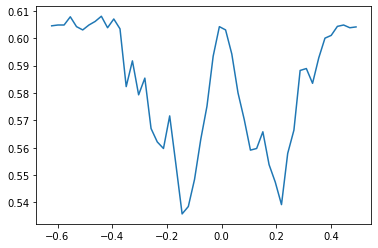

In [ ]:
plt.plot(alpha_vals, acc_list[1:])

In [ ]:
path = 'Saved_models/ResNet18/MNIST/Init_1/'
dict_save_name = path+"Synapse_knockout_data/ResNet18_MNIST_60epochs"

def open_pkl_file(file_name):
  with (open(file_name+".pkl", "rb")) as openfile:
    while True:
        try:
            objects = (pickle.load(openfile))
        except EOFError:
            break

  # df = pd.DataFrame(objects).T
  return objects


file_nums = ['50epochs', '60epochs', '70epochs', '80epochs']
full_dict = {}
for f in file_nums:
  new_file_name = path + "Synapse_knockout_data/ResNet18_MNIST_" + f
  full_dict[f] = open_pkl_file(new_file_name)

print(full_dict.keys())
  

dict_keys(['50epochs', '60epochs', '70epochs', '80epochs'])


In [ ]:
results_dict = full_dict['60epochs']

dict_keys(['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.downsample.0', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.downsample.0', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.downsample.0', 'layer4.1.conv1', 'layer4.1.conv2', 'fc']) 



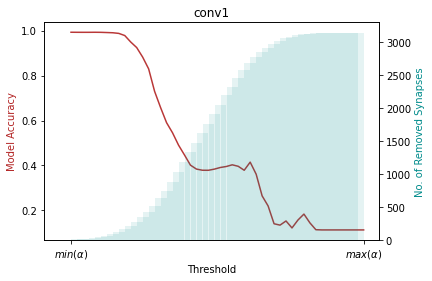

In [ ]:
def normalise_x(x):
  return (x - np.min(x)) / (np.max(x) - np.min(x))


print(results_dict.keys(), "\n")
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
temp_alpha = 0.04

layer = 'conv1'
conv1 = results_dict[layer]
conv_acc, conv_loss, conv_density, conv_x = conv1[0], conv1[1], conv1[2], conv1[3].cpu().numpy()
conv_x = normalise_x(conv_x)

ax2.bar(conv_x, conv_density, alpha=0.1, align='edge', width=-0.04, color='darkcyan')
ax1.plot(conv_x, conv_acc, alpha=0.9, color='firebrick')

ax1.set_xlabel("Threshold")
ax1.set_ylabel('Model Accuracy', color='firebrick')
ax2.set_ylabel('No. of Removed Synapses', color='darkcyan')

xx = [0, 1]
x_ticks_labels = ['$min(\\alpha)$', "$max(\\alpha)$"]

ax1.set_xticks(xx)
ax2.set_xticks(xx)

ax1.set_xticklabels(x_ticks_labels, fontsize=10)
ax2.set_xticklabels(x_ticks_labels, fontsize=10)
plt.title(layer)

plt.show()

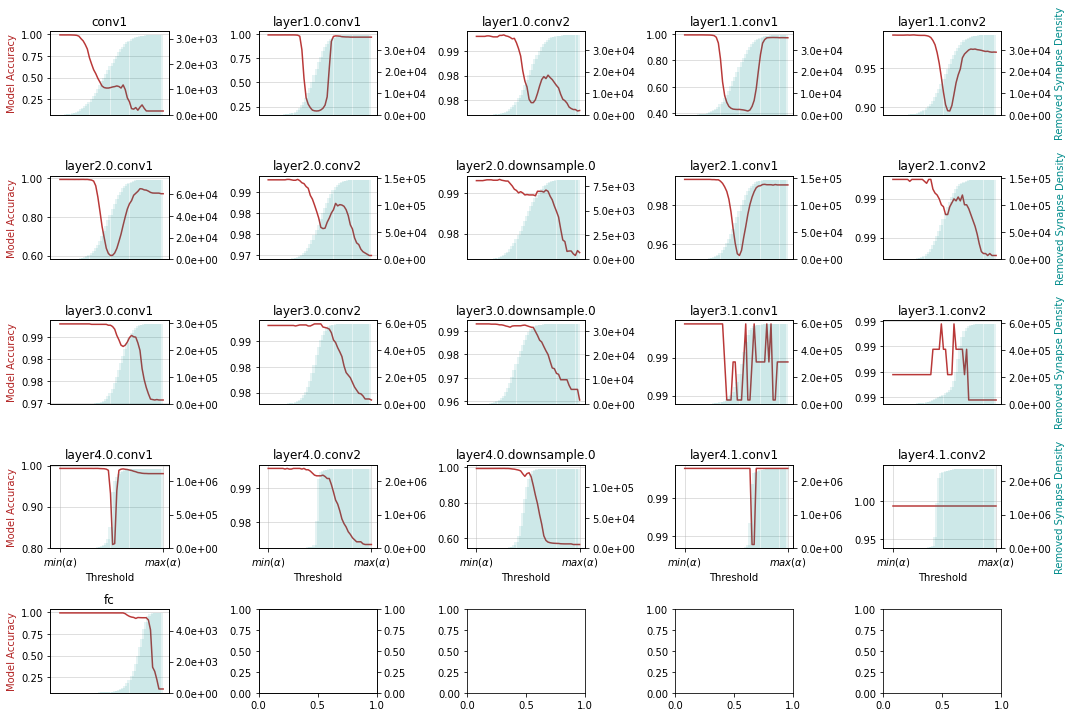

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10))
keys_list = list(results_dict.keys())

counter = 0
for i in range(5):
  for j in range(5):
    axs1 = axs[i, j]
    axs2 = axs1.twinx()

    if counter == 21:
      break

    layer = keys_list[counter]
    counter += 1

    conv = results_dict[layer]
    conv_acc, conv_loss, conv_density, conv_x = conv[0], conv[1], conv[2], conv[3].cpu().numpy()
    conv_x = normalise_x(conv_x)
    
    axs2.bar(conv_x, conv_density, alpha=0.1, align='edge', width=-0.04, color='darkcyan')
    axs1.plot(conv_x, conv_acc, alpha=0.9, color='firebrick')
    
    axs1.yaxis.set_major_formatter(FormatStrFormatter('%1.2f'))
    axs2.yaxis.set_major_formatter(FormatStrFormatter('%1.1e'))

    axs1.locator_params(nbins=4)
    axs2.locator_params(nbins=4)

    axs1.grid(alpha=0.5)

    if j == 0:
      axs1.set_ylabel('Model Accuracy', color='firebrick')

    if j == 4:
      axs2.set_ylabel('Removed Synapse Density', color='darkcyan')

    if i == 3:
      xx = [0, 1]
      x_ticks_labels = ['$min(\\alpha)$', "$max(\\alpha)$"]

      axs1.set_xticks(xx)
      axs2.set_xticks(xx)

      axs1.set_xticklabels(x_ticks_labels, fontsize=10)
      axs2.set_xticklabels(x_ticks_labels, fontsize=10)
      axs1.set_xlabel("Threshold")

    else:
      axs1.get_xaxis().set_visible(False)
      axs2.get_xaxis().set_visible(False)

    if (i == 4) and (j > 0):
        axs1[i, j].set_visible(False)
        axs2[i, j].set_visible(False)

    plt.title(layer)

plt.tight_layout()
plt.show()

In [ ]:
### if needed again later but ddoes not work well with TPU

temp_ = torch.logical_and(filtered_weight > prev, filtered_weight <= next)
# temp_ = torch.logical_and(filtered_weight > -0.5, filtered_weight <= -0.1)

ind = torch.where(temp_)
filtered_weight[ind] *= 0